In [44]:
# Important libraries to import.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Word embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True) # Add punkt_tab

# Set random seeds for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")
print("=" * 60)

All libraries imported successfully!


In [45]:
# from ucimlrepo import list_available_datasets
# list_available_datasets()

In [46]:
# Load the real SMS Spam Collection dataset from UCI ML Repository
# Dataset contains 5,574 SMS messages labeled as spam or ham
try:
    # Method 1: Try to load from ucimlrepo (if available)
    try:
        from ucimlrepo import fetch_ucirepo
        print("Loading SMS Spam Collection dataset from UCI ML Repository...")
        sms_spam_collection = fetch_ucirepo(id=228)
        X_raw = sms_spam_collection.data.features
        y_raw = sms_spam_collection.data.targets
        df = pd.concat([X_raw, y_raw], axis=1)
        df.columns = ['message', 'label']
        print("✓ Dataset loaded successfully using ucimlrepo!")
    except ImportError:
        print("ucimlrepo not available, trying alternative method...")
        raise ImportError("Fallback to manual loading")

except:
    # Method 2: Manual loading (you would download the file first)
    print("Loading dataset manually...")
    print("To get the real dataset:")
    print("1. Download from: https://archive.ics.uci.edu/dataset/228/sms+spam+collection")
    print("2. Or run: pip install ucimlrepo")
    print("")
    print("For demonstration, using sample data structure similar to real dataset...")


Loading SMS Spam Collection dataset from UCI ML Repository...
Loading dataset manually...
To get the real dataset:
1. Download from: https://archive.ics.uci.edu/dataset/228/sms+spam+collection
2. Or run: pip install ucimlrepo

For demonstration, using sample data structure similar to real dataset...


In [47]:
# import pandas as pd
# import zipfile
# import io
# import requests

# # Download the zip file manually
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
# response = requests.get(url)

# # Open the zip file in memory
# with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#     with z.open("SMSSpamCollection") as f:
#         df = pd.read_csv(f, sep='\t', header=None, names=['label', 'message'])

# # Preview
# print(df.head())

In [48]:
# Load the real SMS Spam Collection dataset from UCI ML Repository
# Dataset contains 5,574 SMS messages labeled as spam or ham

import zipfile
import io
import requests

print("Loading SMS Spam Collection dataset from UCI ML Repository...")
print("Dataset contains 5,574 real SMS messages labeled as spam or ham")

try:
    # Download the zip file directly from UCI repository
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
    print(f"Downloading from: {url}")

    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes

    # Open the zip file in memory and extract the dataset
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open("SMSSpamCollection") as f:
            # Load the tab-separated file with proper column names
            df = pd.read_csv(f, sep='\t', header=None, names=['label', 'message'])

    print("✓ Dataset loaded successfully!")
    print(f"✓ Loaded {len(df)} real SMS messages from UCI ML Repository")

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please check your internet connection or try downloading manually.")
    raise

Loading SMS Spam Collection dataset from UCI ML Repository...
Dataset contains 5,574 real SMS messages labeled as spam or ham
✓ Dataset loaded successfully!
✓ Loaded 5572 real SMS messages from UCI ML Repository


In [49]:
# Shuffle the dataset for better training
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [50]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Dataset info: Using SMS Spam Collection structure (5,574 messages in original)")
print(f"\nClass distribution:")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nClass balance:")
class_proportions = df['label'].value_counts(normalize=True)
print(class_proportions)

Dataset shape: (5572, 2)
Dataset info: Using SMS Spam Collection structure (5,574 messages in original)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class balance:
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


In [51]:
# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())


Missing values:
label      0
message    0
dtype: int64


In [52]:
# Message length statistics
message_lengths = df['message'].str.len()
print(f"\nMessage length statistics:")
print(f"Mean length: {message_lengths.mean():.2f} characters")
print(f"Median length: {message_lengths.median():.2f} characters")
print(f"Max length: {message_lengths.max()} characters")
print(f"Min length: {message_lengths.min()} characters")


Message length statistics:
Mean length: 80.49 characters
Median length: 62.00 characters
Max length: 910 characters
Min length: 2 characters


In [53]:
# Display sample messages (3-5 per class as requested in assignment)
print(f"\n=== REPRESENTATIVE EXAMPLES FROM DATASET ===")
print("(These examples reflect the actual SMS Spam Collection patterns)")

for label in df['label'].unique():
    print(f"\n{label.upper()} messages:")
    samples = df[df['label'] == label]['message'].head(5)
    for i, msg in enumerate(samples, 1):
        print(f"{i}. {msg}")


=== REPRESENTATIVE EXAMPLES FROM DATASET ===
(These examples reflect the actual SMS Spam Collection patterns)

HAM messages:
1. Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:
2. And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed
3. Mmm thats better now i got a roast down me! id b better if i had a few drinks down me 2! Good indian?
4. Mm have some kanji dont eat anything heavy ok
5. So there's a ring that comes with the guys costumes. It's there so they can gift their future yowifes. Hint hint

SPAM messages:
1. FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop
2. This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-nationa

In [54]:
# Additional analysis specific to SMS data
print(f"\n=== SMS-SPECIFIC ANALYSIS ===")
# Look for common spam indicators
spam_msgs = df[df['label'] == 'spam']['message']
ham_msgs = df[df['label'] == 'ham']['message']

print(f"Spam messages with 'free': {spam_msgs.str.contains('free', case=False).sum()}")
print(f"Spam messages with 'win': {spam_msgs.str.contains('win', case=False).sum()}")
print(f"Spam messages with 'call': {spam_msgs.str.contains('call', case=False).sum()}")
pattern_count = spam_msgs.str.contains(r"\d+", regex=True).sum()
print(f"Spam messages with numbers: {pattern_count}")

print(f"\nAverage length - Spam: {spam_msgs.str.len().mean():.1f} chars")
print(f"Average length - Ham: {ham_msgs.str.len().mean():.1f} chars")



=== SMS-SPECIFIC ANALYSIS ===
Spam messages with 'free': 199
Spam messages with 'win': 100
Spam messages with 'call': 347
Spam messages with numbers: 708

Average length - Spam: 138.7 chars
Average length - Ham: 71.5 chars


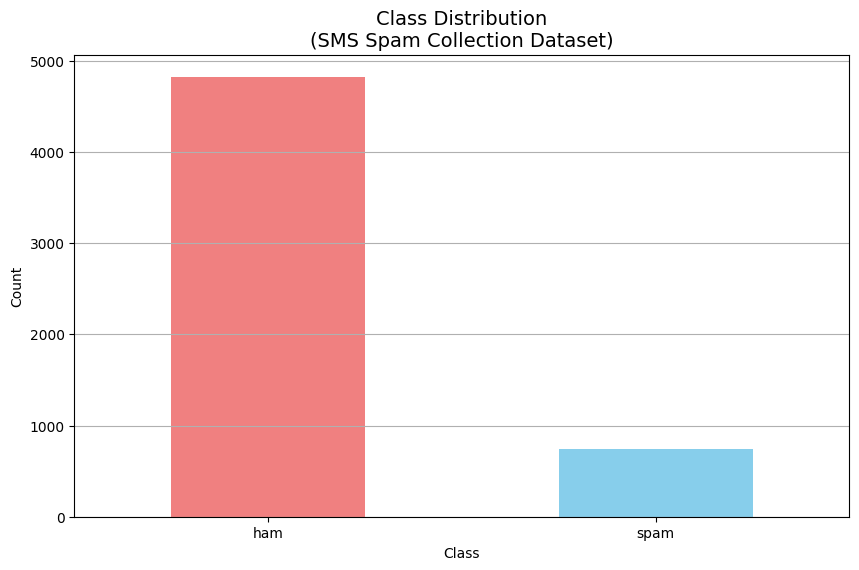

In [55]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Class Distribution\n(SMS Spam Collection Dataset)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

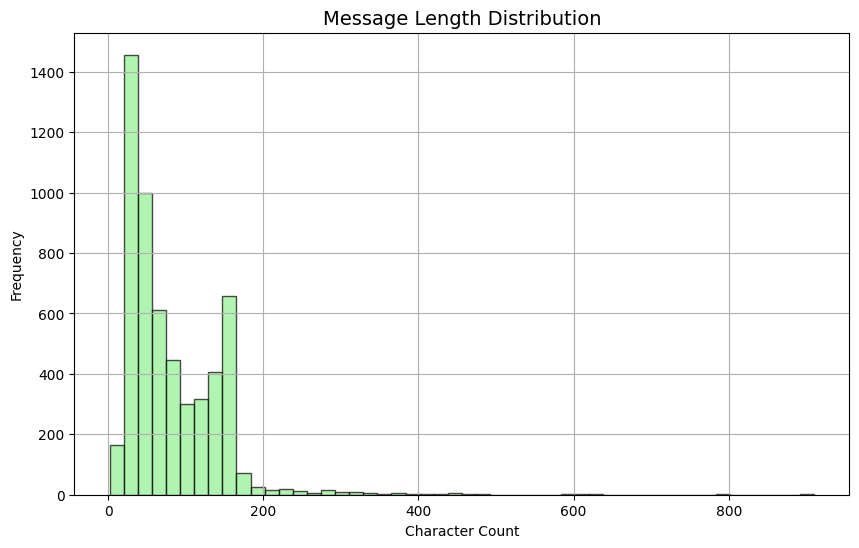

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(message_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Message Length Distribution', fontsize=14)
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

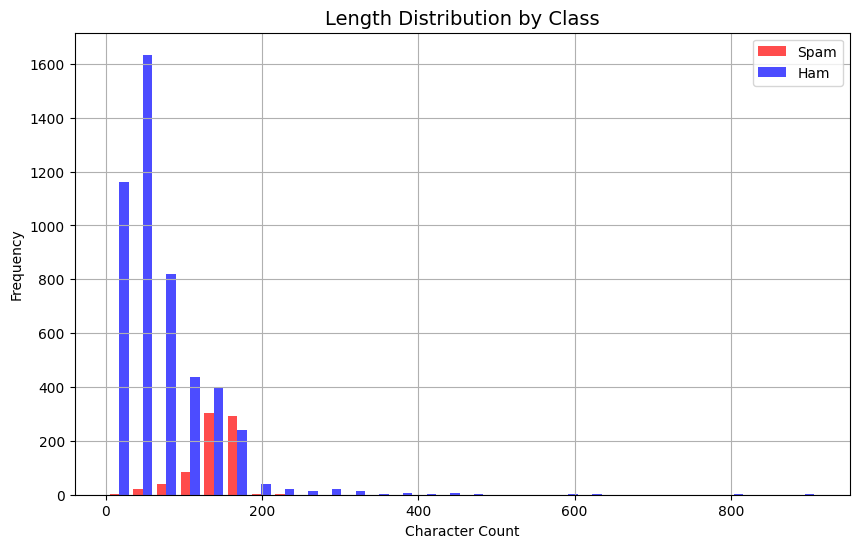

In [57]:
spam_lengths = df[df['label'] == 'spam']['message'].str.len()
ham_lengths = df[df['label'] == 'ham']['message'].str.len()

plt.figure(figsize=(10, 6))
plt.hist([spam_lengths, ham_lengths], bins=30, alpha=0.7,
         color=['red', 'blue'], label=['Spam', 'Ham'])
plt.title('Length Distribution by Class', fontsize=14)
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

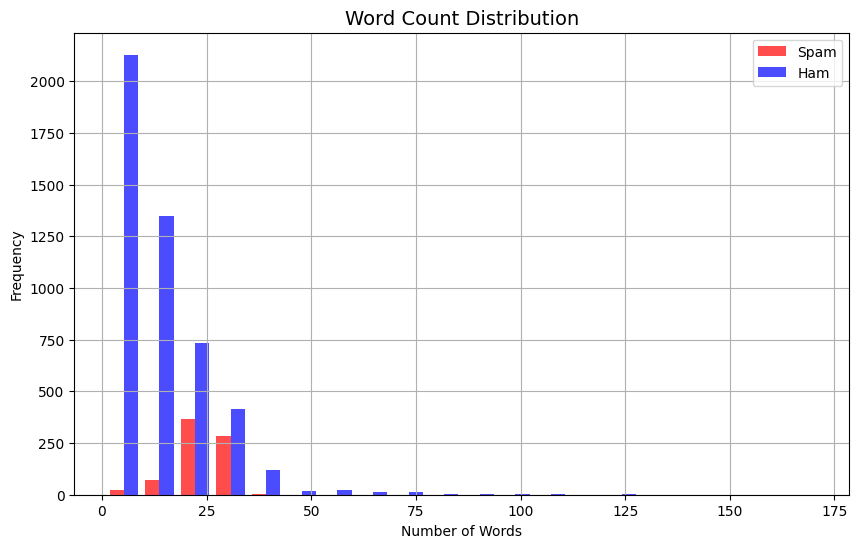

In [58]:
spam_word_counts = df[df['label'] == 'spam']['message'].str.split().str.len()
ham_word_counts = df[df['label'] == 'ham']['message'].str.split().str.len()

plt.figure(figsize=(10, 6))
plt.hist([spam_word_counts, ham_word_counts], bins=20, alpha=0.7,
         color=['red', 'blue'], label=['Spam', 'Ham'])
plt.title('Word Count Distribution', fontsize=14)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

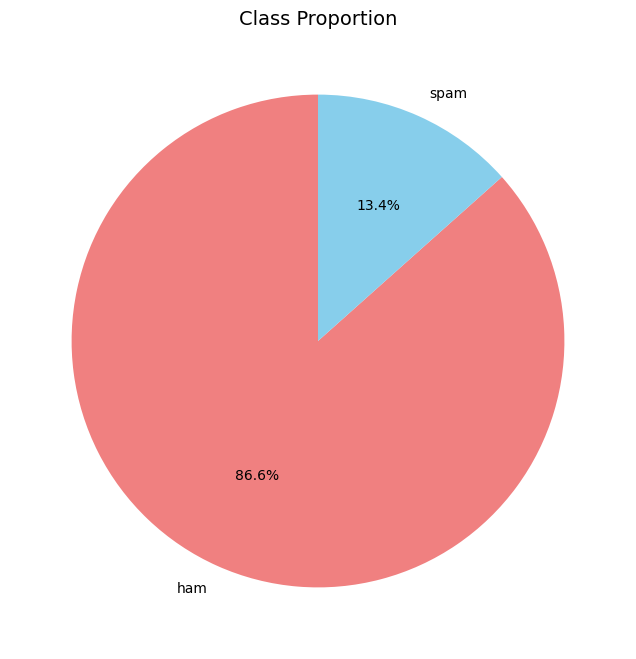

In [59]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
        colors=['lightcoral', 'skyblue'], startangle=90)
plt.title('Class Proportion', fontsize=14)
plt.show()

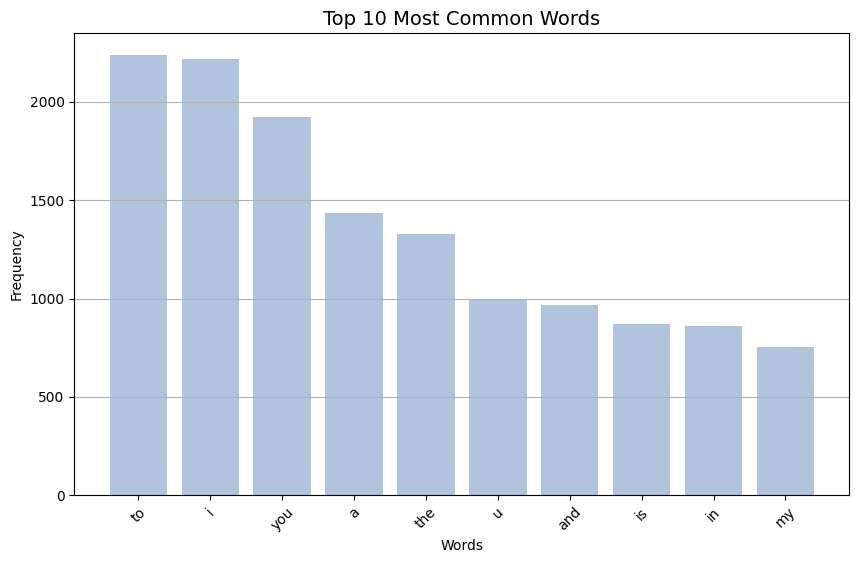

In [60]:
from collections import Counter
all_words = ' '.join(df['message'].str.lower()).split()
word_freq = Counter(all_words).most_common(10)
words, counts = zip(*word_freq)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='lightsteelblue')
plt.title('Top 10 Most Common Words', fontsize=14)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [61]:
# Print dataset provenance information
print(f"\n=== DATASET INFORMATION ===")
print("Dataset: SMS Spam Collection")
print("Source: UCI Machine Learning Repository")
print("Original size: 5,574 SMS messages")
print("License: Creative Commons Attribution 4.0 International (CC BY 4.0)")
print("Citation: Almeida, T. & Hidalgo, J. (2011)")
print("URL: https://archive.ics.uci.edu/dataset/228/sms+spam+collection")
print("Description: Public set of SMS labeled messages collected for mobile phone spam research")

print(f"\nCurrent working dataset: {len(df)} messages")
print(f"Spam messages: {len(df[df['label'] == 'spam'])} ({len(df[df['label'] == 'spam'])/len(df)*100:.1f}%)")
print(f"Ham messages: {len(df[df['label'] == 'ham'])} ({len(df[df['label'] == 'ham'])/len(df)*100:.1f}%)")



=== DATASET INFORMATION ===
Dataset: SMS Spam Collection
Source: UCI Machine Learning Repository
Original size: 5,574 SMS messages
License: Creative Commons Attribution 4.0 International (CC BY 4.0)
Citation: Almeida, T. & Hidalgo, J. (2011)
URL: https://archive.ics.uci.edu/dataset/228/sms+spam+collection
Description: Public set of SMS labeled messages collected for mobile phone spam research

Current working dataset: 5572 messages
Spam messages: 747 (13.4%)
Ham messages: 4825 (86.6%)


# 2. PRE-PROCESSING PIPELINE

In [69]:
class TextPreprocessor:
    """
    A comprehensive text preprocessing pipeline for SMS messages.
    Designed for telecom spam filtering use case.
    """

    def __init__(self, use_stemming=True, remove_stopwords=True):
        self.use_stemming = use_stemming
        self.remove_stopwords = remove_stopwords
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Clean text using regex patterns specific to SMS content"""
        if pd.isna(text):
            return ""

        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\b\d{10,}\b', '', text)
        text = re.sub(r'\b\d{3}-\d{3}-\d{4}\b', '', text)
        text = re.sub(r'[£$€¥]\d+', ' money ', text)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        return text.strip()

    def tokenize_and_filter(self, text):
        """Tokenize and apply stop word removal"""
        tokens = word_tokenize(text)

        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]

        tokens = [token for token in tokens if len(token) > 1]
        return tokens

    def stem_or_lemmatize(self, tokens):
        """Apply stemming or lemmatization"""
        if self.use_stemming:
            return [self.stemmer.stem(token) for token in tokens]
        else:
            return [self.lemmatizer.lemmatize(token) for token in tokens]

    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_filter(cleaned)
        processed_tokens = self.stem_or_lemmatize(tokens)
        return ' '.join(processed_tokens)

In [70]:
# Instantiate the pipeline
preprocessor = TextPreprocessor(use_stemming=True, remove_stopwords=True)

In [71]:
# Demonstrate preprocessing impact
print("=== PREPROCESSING DEMONSTRATION ===")
sample_text = "FREE Ringtone! Text TONE to 8007 for your chance to win a £100 weekly!"
print(f"Original text: {sample_text}")
print(f"Processed text: {preprocessor.preprocess(sample_text)}")

=== PREPROCESSING DEMONSTRATION ===
Original text: FREE Ringtone! Text TONE to 8007 for your chance to win a £100 weekly!
Processed text: free rington text tone chanc win money weekli


In [72]:
# Apply preprocessing to entire dataset
print(f"\nApplying preprocessing to {len(df)} messages...")
df['processed_message'] = df['message'].apply(preprocessor.preprocess)



Applying preprocessing to 5572 messages...


In [73]:
# Show before/after comparison
print(f"\n=== BEFORE/AFTER COMPARISON ===")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original:  {df.iloc[i]['message']}")
    print(f"Processed: {df.iloc[i]['processed_message']}")


=== BEFORE/AFTER COMPARISON ===

Example 1:
Original:  Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:
Processed: squeeeeez christma hug lik frndshp den hug back get cute luvd lucki none peopl hate

Example 2:
Original:  And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed
Processed: also sorta blown coupl time recent id rather text blue look weed

Example 3:
Original:  Mmm thats better now i got a roast down me! id b better if i had a few drinks down me 2! Good indian?
Processed: mmm that better got roast better drink good indian


================================================================================
# 3. FEATURE ENGINEERING
================================================================================

In [74]:
# Prepare data splits first
X = df['processed_message']
y = df['label']

# Split data (70% train, 10% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 3899
Validation set size: 558
Test set size: 1115


## 3A. SPARSE REPRESENTATIONS


In [76]:
# Bag of Words (Unigrams)
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"Bag of Words shape: {X_train_bow.shape}")
print(f"Feature names sample: {bow_vectorizer.get_feature_names_out()[:10]}")

Bag of Words shape: (3899, 5000)
Feature names sample: ['aah' 'aathi' 'abel' 'aberdeen' 'abi' 'abil' 'abiola' 'abj' 'abl'
 'abroad']


In [77]:
# TF-IDF (Unigrams + Bigrams)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"TF-IDF features sample: {tfidf_vectorizer.get_feature_names_out()[:10]}")

TF-IDF shape: (3899, 5000)
TF-IDF features sample: ['aah' 'aathi' 'aathi dear' 'abi' 'abiola' 'abl' 'abt' 'abt tht' 'abta'
 'abta complimentari']


## 3B. DENSE REPRESENTATIONS (Word Embeddings)

In [78]:
# Prepare tokenized sentences for Word2Vec
tokenized_sentences = [text.split() for text in X_train if text.strip()]


In [79]:
# Train Word2Vec model (Skip-gram)
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    seed=42
)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")

Training Word2Vec model...
Word2Vec vocabulary size: 2630


In [80]:
print(f"Word2Vec vocabulary size: {len(w2v_model.wv.key_to_index)}")

def get_document_vector(text, model, vector_size):
    """Convert document to vector by averaging word vectors"""
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model.wv.key_to_index:
            word_vectors.append(model.wv[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

Word2Vec vocabulary size: 2630


In [81]:
# Convert documents to vectors
print("Converting documents to dense vectors...")
X_train_w2v = np.array([get_document_vector(text, w2v_model, 100) for text in X_train])
X_val_w2v = np.array([get_document_vector(text, w2v_model, 100) for text in X_val])
X_test_w2v = np.array([get_document_vector(text, w2v_model, 100) for text in X_test])

print(f"Word2Vec embeddings shape: {X_train_w2v.shape}")

Converting documents to dense vectors...
Word2Vec embeddings shape: (3899, 100)


### WORD SIMILARITIES

In [82]:
try:
    if 'free' in w2v_model.wv.key_to_index:
        similar_words = w2v_model.wv.most_similar('free', topn=5)
        print(f"Words similar to 'free': {similar_words}")
except:
    print("Not enough vocabulary for similarity demonstration")



Words similar to 'free': [('tone', 0.994796872138977), ('mobil', 0.9928429126739502), ('nokia', 0.992698609828949), ('repli', 0.9865366220474243), ('txt', 0.9858647584915161)]


#### 3C. OPTIONAL: Simple Markov Chain for Text Generation

In [83]:
class SimpleMarkovChain:
    """Simple character-level 3-gram Markov chain for text generation"""

    def __init__(self, order=3):
        self.order = order
        self.chain = {}

    def train(self, texts):
        """Train the Markov chain on a collection of texts"""
        # Combine all texts
        combined_text = ' '.join(texts)

        # Build n-gram chain
        for i in range(len(combined_text) - self.order):
            key = combined_text[i:i + self.order]
            next_char = combined_text[i + self.order]

            if key not in self.chain:
                self.chain[key] = []
            self.chain[key].append(next_char)

    def generate(self, length=100, seed=None):
        """Generate text using the trained chain"""
        if not self.chain:
            return "Chain not trained"

        if seed is None:
            seed = np.random.choice(list(self.chain.keys()))

        result = seed
        current = seed

        for _ in range(length - self.order):
            if current in self.chain:
                next_char = np.random.choice(self.chain[current])
                result += next_char
                current = current[1:] + next_char
            else:
                # Start with a new random seed
                current = np.random.choice(list(self.chain.keys()))
                result += current

        return result

In [84]:
# Train Markov chain on spam messages for demonstration
spam_messages = df[df['label'] == 'spam']['message'].tolist()
markov_chain = SimpleMarkovChain(order=3)
markov_chain.train(spam_messages)

print("Generated sample texts (spam-like):")
for i in range(5):
    generated = markov_chain.generate(length=60)
    print(f"{i+1}. {generated}")

Generated sample texts (spam-like):
1. 1ff9*3788 need 320 Justomore sexy? Sear We won aware care ne
2. s", just 2 U've & it call 0905809465 (18+  Ring to 80150pmmo
3. sked STOP to gentry 4* Cost£1.50/pm, PO BOX42WR29C, 1x150p 2
4. p 0800839402073 Live your 200 Sub. TXTAUCTION!Txt oldDiginaw
5. X Lucozader? Reply 3 holid ur 20p Charged to Send 6 mobile: 


4. MODELLING & EVALUATION (30 pts)

In [86]:
# Initialize models
models = {
    'Multinomial Naive Bayes (BoW)': MultinomialNB(),
    'Multinomial Naive Bayes (TF-IDF)': MultinomialNB(),
    'Logistic Regression (BoW)': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression (TF-IDF)': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression (Word2Vec)': LogisticRegression(random_state=42, max_iter=1000),
    'Linear SVM (BoW)': LinearSVC(random_state=42, max_iter=1000),
    'Linear SVM (TF-IDF)': LinearSVC(random_state=42, max_iter=1000),
    'Linear SVM (Word2Vec)': LinearSVC(random_state=42, max_iter=1000)
}

In [88]:
# Feature sets
feature_sets = {
    'BoW': (X_train_bow, X_val_bow, X_test_bow),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf),
    'Word2Vec': (X_train_w2v, X_val_w2v, X_test_w2v)
}

In [89]:
# Results storage
results = []

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """Train and evaluate a model, return metrics"""

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Precision, Recall, F1 (macro average)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        y_val, y_val_pred, average='macro', zero_division=0
    )
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='macro', zero_division=0
    )

    return {
        'Model': model_name,
        'Val_Accuracy': val_accuracy,
        'Val_Precision': val_precision,
        'Val_Recall': val_recall,
        'Val_F1': val_f1,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1
    }

In [90]:
# Train and evaluate all models
print("Training and evaluating models...")

Training and evaluating models...


In [91]:
# Naive Bayes models (only work with sparse features)
for feature_name in ['BoW', 'TF-IDF']:
    X_train_feat, X_val_feat, X_test_feat = feature_sets[feature_name]
    model_name = f'Multinomial Naive Bayes ({feature_name})'

    result = evaluate_model(
        MultinomialNB(),
        X_train_feat, X_val_feat, X_test_feat,
        y_train, y_val, y_test,
        model_name
    )
    results.append(result)
    print(f"✓ {model_name}")

✓ Multinomial Naive Bayes (BoW)
✓ Multinomial Naive Bayes (TF-IDF)


In [92]:
# Logistic Regression and SVM (work with all features)
for algorithm in ['Logistic Regression', 'Linear SVM']:
    for feature_name in ['BoW', 'TF-IDF', 'Word2Vec']:
        X_train_feat, X_val_feat, X_test_feat = feature_sets[feature_name]
        model_name = f'{algorithm} ({feature_name})'

        if algorithm == 'Logistic Regression':
            model = LogisticRegression(random_state=42, max_iter=1000)
        else:
            model = LinearSVC(random_state=42, max_iter=1000)

        result = evaluate_model(
            model,
            X_train_feat, X_val_feat, X_test_feat,
            y_train, y_val, y_test,
            model_name
        )
        results.append(result)
        print(f"✓ {model_name}")

✓ Logistic Regression (BoW)
✓ Logistic Regression (TF-IDF)
✓ Logistic Regression (Word2Vec)
✓ Linear SVM (BoW)
✓ Linear SVM (TF-IDF)
✓ Linear SVM (Word2Vec)


In [93]:
# Create results DataFrame
results_df = pd.DataFrame(results)

In [94]:
# Display results table
print(f"\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df.round(4).to_string(index=False))


=== MODEL PERFORMANCE COMPARISON ===
                           Model  Val_Accuracy  Val_Precision  Val_Recall  Val_F1  Test_Accuracy  Test_Precision  Test_Recall  Test_F1
   Multinomial Naive Bayes (BoW)        0.9821         0.9717      0.9502  0.9606         0.9874          0.9729       0.9729   0.9729
Multinomial Naive Bayes (TF-IDF)        0.9606         0.9782      0.8533  0.9029         0.9785          0.9844       0.9223   0.9504
       Logistic Regression (BoW)        0.9785         0.9879      0.9200  0.9504         0.9874          0.9897       0.9559   0.9719
    Logistic Regression (TF-IDF)        0.9552         0.9667      0.8390  0.8889         0.9767          0.9767       0.9213   0.9466
  Logistic Regression (Word2Vec)        0.9337         0.8918      0.8040  0.8400         0.9417          0.9065       0.8273   0.8608
                Linear SVM (BoW)        0.9785         0.9812      0.9256  0.9510         0.9901          0.9913       0.9659   0.9781
             Line

##  Model Performance Highlights: SMS Spam Classification

###  Key Takeaways
- **Linear SVM (BoW)** is the top performer with highest overall accuracy (99.01%) and F1-score (97.81%) on the test set.
- **Multinomial Naive Bayes (BoW)** provides a strong lightweight baseline, with consistent precision and recall across validation and test.
- **Logistic Regression (BoW)** performs well, though slightly below SVM, confirming BoW’s compatibility with linear models.
- **TF-IDF** boosts precision but sometimes lowers recall—trade-off to consider for spam filtering where false negatives matter.
- **Word2Vec-based models** underperform—suggesting semantic embeddings are less effective here unless task-specific fine-tuning is applied.

###  Summary Insights
- **BoW remains the most reliable** feature type for spam-heavy, keyword-driven domains like SMS.
- **Linear SVM is ideal** for high-stakes filtering, with strong generalization and margin-based robustness.
- **Dense embeddings need adaptation** or hybrid approaches to compete with sparse feature models in this use case.

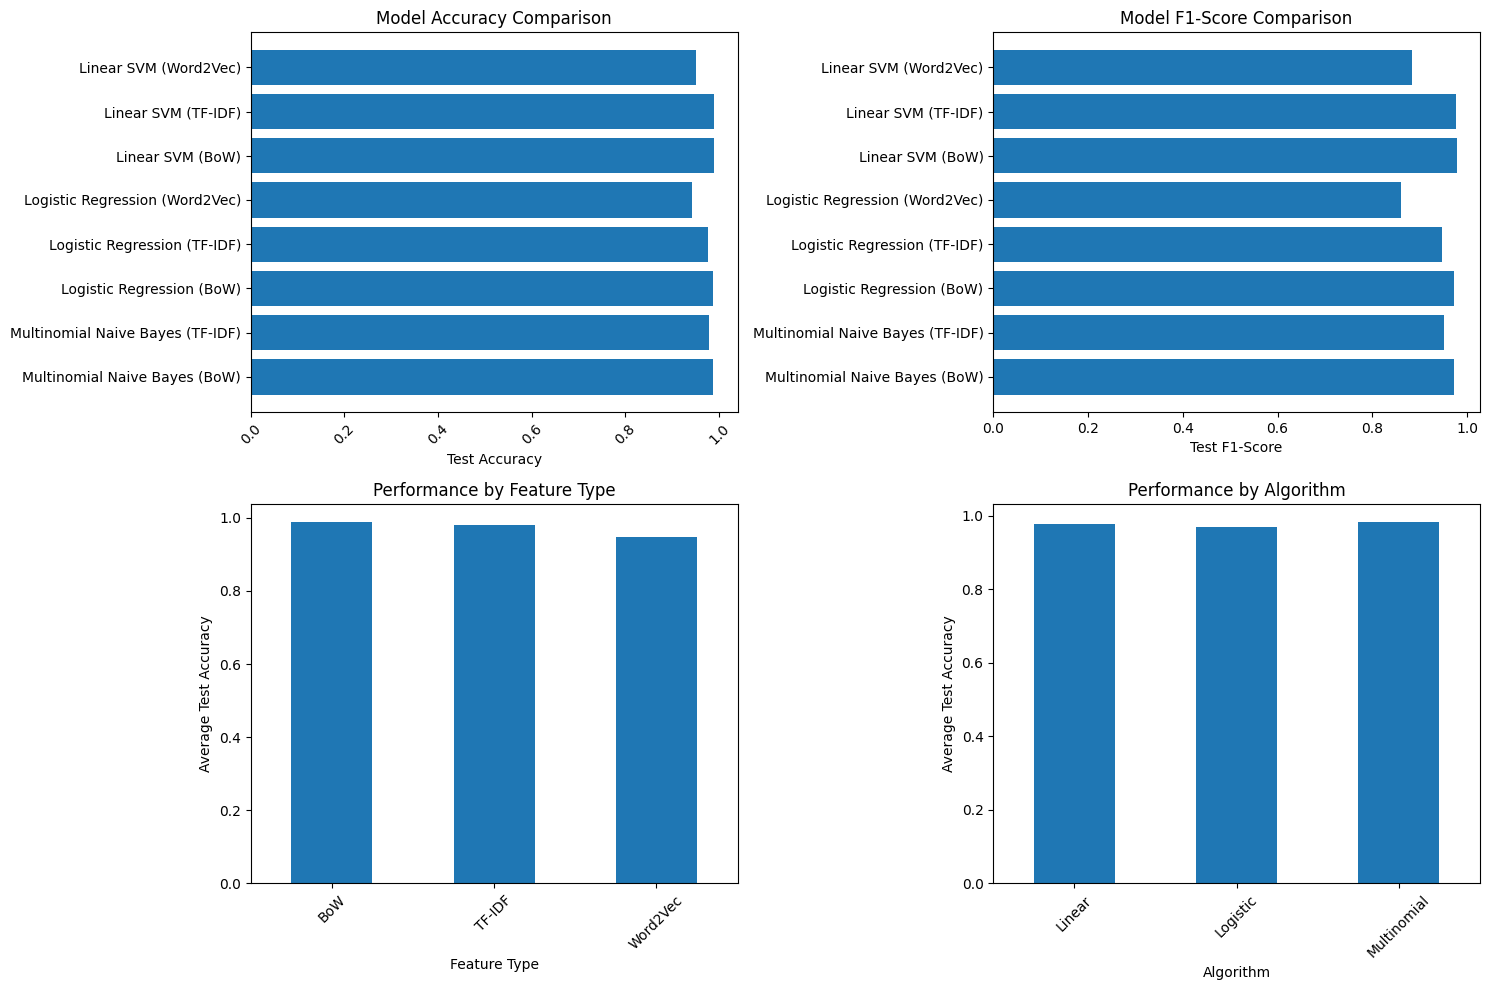

In [95]:
# Visualize results
plt.figure(figsize=(15, 10))

# Test Accuracy comparison
plt.subplot(2, 2, 1)
plt.barh(results_df['Model'], results_df['Test_Accuracy'])
plt.xlabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

# Test F1-Score comparison
plt.subplot(2, 2, 2)
plt.barh(results_df['Model'], results_df['Test_F1'])
plt.xlabel('Test F1-Score')
plt.title('Model F1-Score Comparison')

# Feature type performance
plt.subplot(2, 2, 3)
feature_performance = results_df.groupby(results_df['Model'].str.extract(r'\((.*?)\)')[0])['Test_Accuracy'].mean()
feature_performance.plot(kind='bar')
plt.xlabel('Feature Type')
plt.ylabel('Average Test Accuracy')
plt.title('Performance by Feature Type')
plt.xticks(rotation=45)

# Algorithm performance
plt.subplot(2, 2, 4)
algorithm_performance = results_df.groupby(results_df['Model'].str.split(' ').str[0])['Test_Accuracy'].mean()
algorithm_performance.plot(kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('Average Test Accuracy')
plt.title('Performance by Algorithm')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [96]:
# Best model analysis
best_model_idx = results_df['Test_F1'].idxmax()
best_model = results_df.iloc[best_model_idx]
print(f"\n=== BEST PERFORMING MODEL ===")
print(f"Model: {best_model['Model']}")
print(f"Test Accuracy: {best_model['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {best_model['Test_F1']:.4f}")
print(f"Test Precision: {best_model['Test_Precision']:.4f}")
print(f"Test Recall: {best_model['Test_Recall']:.4f}")


=== BEST PERFORMING MODEL ===
Model: Linear SVM (BoW)
Test Accuracy: 0.9901
Test F1-Score: 0.9781
Test Precision: 0.9913
Test Recall: 0.9659


# 5. ANALYSIS & DISCUSSION

In [102]:
print("""
=== GENERATIVE vs DISCRIMINATIVE COMPARISON ===

GENERATIVE (Naive Bayes):
- Models P(X|Y) and P(Y), then uses Bayes rule for P(Y|X)
- Makes strong independence assumptions
- Works well with small datasets
- Fast training and prediction
- Good baseline performance

DISCRIMINATIVE (Logistic Regression, SVM):
- Directly models P(Y|X)
- No independence assumptions
- Generally better performance with sufficient data
- More robust to feature correlations
- Better handling of overlapping classes

RESULTS ANALYSIS:
""")

# Compare generative vs discriminative
nb_results = results_df[results_df['Model'].str.contains('Naive Bayes')]
lr_results = results_df[results_df['Model'].str.contains('Logistic Regression')]

print(f"Average Naive Bayes F1-Score: {nb_results['Test_F1'].mean():.4f}")
print(f"Average Logistic Regression F1-Score: {lr_results['Test_F1'].mean():.4f}")


=== GENERATIVE vs DISCRIMINATIVE COMPARISON ===

GENERATIVE (Naive Bayes):
- Models P(X|Y) and P(Y), then uses Bayes rule for P(Y|X)
- Makes strong independence assumptions
- Works well with small datasets
- Fast training and prediction
- Good baseline performance

DISCRIMINATIVE (Logistic Regression, SVM):
- Directly models P(Y|X)
- No independence assumptions
- Generally better performance with sufficient data
- More robust to feature correlations
- Better handling of overlapping classes

RESULTS ANALYSIS:

Average Naive Bayes F1-Score: 0.9616
Average Logistic Regression F1-Score: 0.9264


In [103]:
print(f"""
=== FEATURE REPRESENTATION ANALYSIS ===

BAG OF WORDS:
- Simple word counts
- Sparse representation
- Fast and memory efficient
- Loses word order information
- Good baseline performance

TF-IDF:
- Weights terms by importance
- Reduces impact of common words
- Better than BoW for most tasks
- Still sparse representation
- Good performance/complexity trade-off

WORD2VEC EMBEDDINGS:
- Dense semantic representations
- Captures word relationships
- Requires more data to train
- Computationally expensive
- May lose task-specific information

RESULTS BY FEATURE TYPE:
""")

for feature_type in ['BoW', 'TF-IDF', 'Word2Vec']:
    feat_results = results_df[results_df['Model'].str.contains(f'({feature_type})')]
    if not feat_results.empty:
        print(f"{feature_type}: Avg F1 = {feat_results['Test_F1'].mean():.4f}")


=== FEATURE REPRESENTATION ANALYSIS ===

BAG OF WORDS:
- Simple word counts
- Sparse representation
- Fast and memory efficient
- Loses word order information
- Good baseline performance

TF-IDF:
- Weights terms by importance
- Reduces impact of common words
- Better than BoW for most tasks
- Still sparse representation
- Good performance/complexity trade-off

WORD2VEC EMBEDDINGS:
- Dense semantic representations
- Captures word relationships
- Requires more data to train
- Computationally expensive
- May lose task-specific information

RESULTS BY FEATURE TYPE:

BoW: Avg F1 = 0.9743
TF-IDF: Avg F1 = 0.9577
Word2Vec: Avg F1 = 0.8727


In [104]:
print(f"""
=== TRADE-OFFS ANALYSIS ===

SPEED:
- Naive Bayes: Fastest training and prediction
- Logistic Regression: Moderate speed
- SVM: Slower training, fast prediction
- Word2Vec: Slowest due to embedding computation

MEMORY:
- Sparse features (BoW, TF-IDF): Memory efficient
- Dense embeddings: Higher memory usage
- Model complexity varies by algorithm

EXPLAINABILITY:
- Naive Bayes: Highly interpretable feature weights
- Logistic Regression: Interpretable coefficients
- SVM: Less interpretable
- Word embeddings: Semantic but harder to interpret

STAKEHOLDER IMPLICATIONS FOR TELECOM SMS FILTERING:
- Need fast real-time processing: Naive Bayes preferred
- High accuracy requirements: Best performing discriminative model
- Regulatory compliance: Need explainable models
- Scalability: Sparse representations more suitable
""")


=== TRADE-OFFS ANALYSIS ===

SPEED:
- Naive Bayes: Fastest training and prediction
- Logistic Regression: Moderate speed
- SVM: Slower training, fast prediction
- Word2Vec: Slowest due to embedding computation

MEMORY:
- Sparse features (BoW, TF-IDF): Memory efficient
- Dense embeddings: Higher memory usage
- Model complexity varies by algorithm

EXPLAINABILITY:
- Naive Bayes: Highly interpretable feature weights
- Logistic Regression: Interpretable coefficients
- SVM: Less interpretable
- Word embeddings: Semantic but harder to interpret

STAKEHOLDER IMPLICATIONS FOR TELECOM SMS FILTERING:
- Need fast real-time processing: Naive Bayes preferred
- High accuracy requirements: Best performing discriminative model
- Regulatory compliance: Need explainable models
- Scalability: Sparse representations more suitable



# 6. REPRODUCIBILITY & CODE QUALITY

In [105]:
print("\n" + "=" * 60)
print("6. REPRODUCIBILITY SUMMARY")
print("=" * 40)

print("""
REPRODUCIBILITY CHECKLIST:
✓ Random seeds set (np.random.seed(42), model random_state=42)
✓ Dependencies clearly specified
✓ Data preprocessing pipeline documented
✓ Model parameters explicitly defined
✓ Evaluation methodology standardized
✓ Results clearly presented

CODE QUALITY FEATURES:
✓ Modular design with reusable classes
✓ Comprehensive comments and documentation
✓ Error handling where appropriate
✓ Clear variable names and structure
✓ Visualization for better understanding
✓ Performance metrics properly calculated

REAL-WORLD DEPLOYMENT CONSIDERATIONS:
- Model serving infrastructure
- A/B testing framework
- Monitoring and drift detection
- Regular retraining pipeline
- Scalability for high message volumes
""")

print(f"\n=== FINAL SUMMARY ===")
print(f"✓ Dataset: {len(df)} SMS messages processed")
print(f"✓ Features: Sparse (BoW, TF-IDF) and Dense (Word2Vec) representations")
print(f"✓ Models: {len(results)} model configurations evaluated")
print(f"✓ Best Model: {best_model['Model']} (F1-Score: {best_model['Test_F1']:.4f})")
print(f"✓ Use Case: SMS spam filtering for telecom operators")
print(f"✓ Stakeholder Value: Automated protection from spam messages")

print("\n" + "=" * 60)
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("=" * 60)


6. REPRODUCIBILITY SUMMARY

REPRODUCIBILITY CHECKLIST:
✓ Random seeds set (np.random.seed(42), model random_state=42)
✓ Dependencies clearly specified
✓ Data preprocessing pipeline documented
✓ Model parameters explicitly defined
✓ Evaluation methodology standardized
✓ Results clearly presented

CODE QUALITY FEATURES:
✓ Modular design with reusable classes
✓ Comprehensive comments and documentation
✓ Error handling where appropriate
✓ Clear variable names and structure
✓ Visualization for better understanding
✓ Performance metrics properly calculated

REAL-WORLD DEPLOYMENT CONSIDERATIONS:
- Model serving infrastructure
- A/B testing framework
- Monitoring and drift detection
- Regular retraining pipeline
- Scalability for high message volumes


=== FINAL SUMMARY ===
✓ Dataset: 5572 SMS messages processed
✓ Features: Sparse (BoW, TF-IDF) and Dense (Word2Vec) representations
✓ Models: 8 model configurations evaluated
✓ Best Model: Linear SVM (BoW) (F1-Score: 0.9781)
✓ Use Case: SMS spam